<a href="https://colab.research.google.com/github/mikonvergence/DiffusionFastForward/blob/master/04-Latent-Diffusion-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> This is part of [DiffusionFastForward](https://github.com/mikonvergence/DiffusionFastForward) course. For more content, please go to https://github.com/mikonvergence/DiffusionFastForward.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git clone https://github.com/mikonvergence/DiffusionFastForward
!pip install pytorch-lightning==1.9.3 diffusers einops kornia

Cloning into 'DiffusionFastForward'...


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/826.4 kB ? eta -:--:--
     ---------------------------------------- 10.2/826.4 kB ? eta -:--:--
     ---------------------------------------- 10.2/826.4 kB ? eta -:--:--
     --- --------------------------------- 71.7/826.4 kB 393.8 kB/s eta 0:00:02
     ----------- -------------------------- 245.8/826.4 kB 1.2 MB/s eta 0:00:01
     ----------------------- -------------- 501.8/826.4 kB 1.8 MB/s eta 0:00:01
     -------------------------------- ----- 706.6/826.4 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 826.4/826.4 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.8 MB 4.8 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/1.8 MB 5.0 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.8 MB 4.5 MB/s eta 0:00:01
   ------

In [3]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xf maps.tar.gz
!rm maps.tar.gz

--2024-01-14 15:56:39--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: `maps.tar.gz'

     0K .......... .......... .......... .......... ..........  0% 58.4K 69m42s
    50K .......... .......... .......... .......... ..........  0%  224K 43m56s
   100K .......... .......... .......... .......... ..........  0%  230K 35m12s
   150K .......... .......... .......... .......... ..........  0%  116K 35m9s
   200K .......... .......... .......... .......... ..........  0%  225K 31m43s
   250K .......... .......... .......... .......... ..........  0%  119K 32m9s
   300K .......... .......... .......... .......... ..........  0%  231K 30m4s
   350K .......... .......... .......... .......... ..........  0%  229K 28m31s
   400K .......... .....

# Unconditional Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusion` model in low resolution (64 by 64).

The training should take about 20 hours for reasonable results.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
!rm maps.tar.gz
```

Ideally, you will download this dataset once and store it as `data/maps`. If you're running on colab, it's a good idea to download it once to your personal machine (it's only 240 MB) and then upload it to your colab space when you start a new notebook.

In [7]:
import sys
sys.path.append('./DiffusionFastForward/')

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

c:\Users\nguye\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair

        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )

        # check files
        supported_formats=['webp','jpg']
        self.files=[el for el in os.listdir(self.root_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image2,image
        else:
            return image

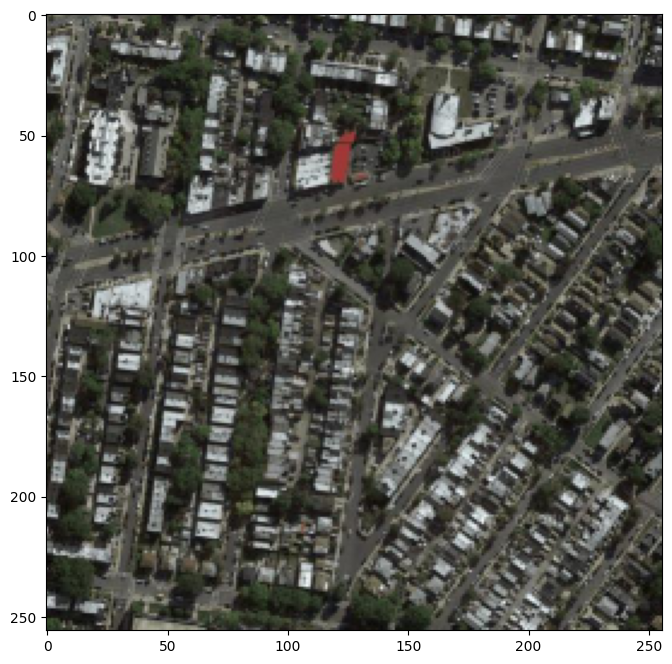

In [9]:
import torchvision.transforms as T

CROP_SIZE=256

T=[
    KA.RandomCrop((2*CROP_SIZE,2*CROP_SIZE)),
    KA.Resize((CROP_SIZE,CROP_SIZE),antialias=True),
    KA.RandomVerticalFlip()
  ]

train_ds=SimpleImageDataset('./maps/train',
                      transforms=T
                     )

test_ds=SimpleImageDataset('./maps/val',
                      transforms=T
                     )

img=train_ds[0]

plt.imshow(img.permute(1,2,0))

### Model Training

In [10]:
model=LatentDiffusion(train_ds,
                      lr=1e-4,
                      batch_size=8)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
config.json: 100%|██████████| 547/547 [00:00<00:00, 109kB/s]
diffusion_pytorch_model.safetensors: 100%|██████████| 335M/335M [01:24<00:00, 3.97MB/s] 


OSError: Unable to load weights from checkpoint file for 'C:\Users\nguye\.cache\huggingface\hub\models--stabilityai--sd-vae-ft-ema\snapshots\f04b2c4b98319346dad8c65879f680b1997b204a\diffusion_pytorch_model.safetensors' at 'C:\Users\nguye\.cache\huggingface\hub\models--stabilityai--sd-vae-ft-ema\snapshots\f04b2c4b98319346dad8c65879f680b1997b204a\diffusion_pytorch_model.safetensors'. If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True.

In [ ]:
trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    gpus = [0]
)

In [ ]:
trainer.fit(model)

In [ ]:
B=8 # number of samples

model.cuda()
out=model(batch_size=B,shape=(64,64),verbose=True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
B=8 # number of samples
STEPS=200 # ddim steps

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_size=B,sampler=ddim_sampler,shape=(64,64),verbose=True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')